In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
from transformers import pipeline
import tf_keras as keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df = pd.read_csv('Sentiment_analysis_dataset.csv')

print(f'Total number of rows: {len(df)}')

print(f'Number of rows containing null values: {df.isnull().any(axis=1).sum()}')
df.head()

Total number of rows: 37130
Number of rows containing null values: 254


,Statement,Status
0,life doesn’t feel worth it that’s kind of it? ...,Depression
1,This life sucks and if it were for my religiou...,Depression
2,its been 9 months now for our marriage and she...,Stress
3,I do not feel particularly sad or anxious or a...,Depression
4,I am taking Venlafaxine. it is an SSRI. does n...,Depression


Number of duplicate rows: 796
Status
Normal                  176
Depression              148
Bipolar                 140
Stress                  129
Anxiety                 105
Personality disorder     94
Suicidal                  4
Name: count, dtype: int64


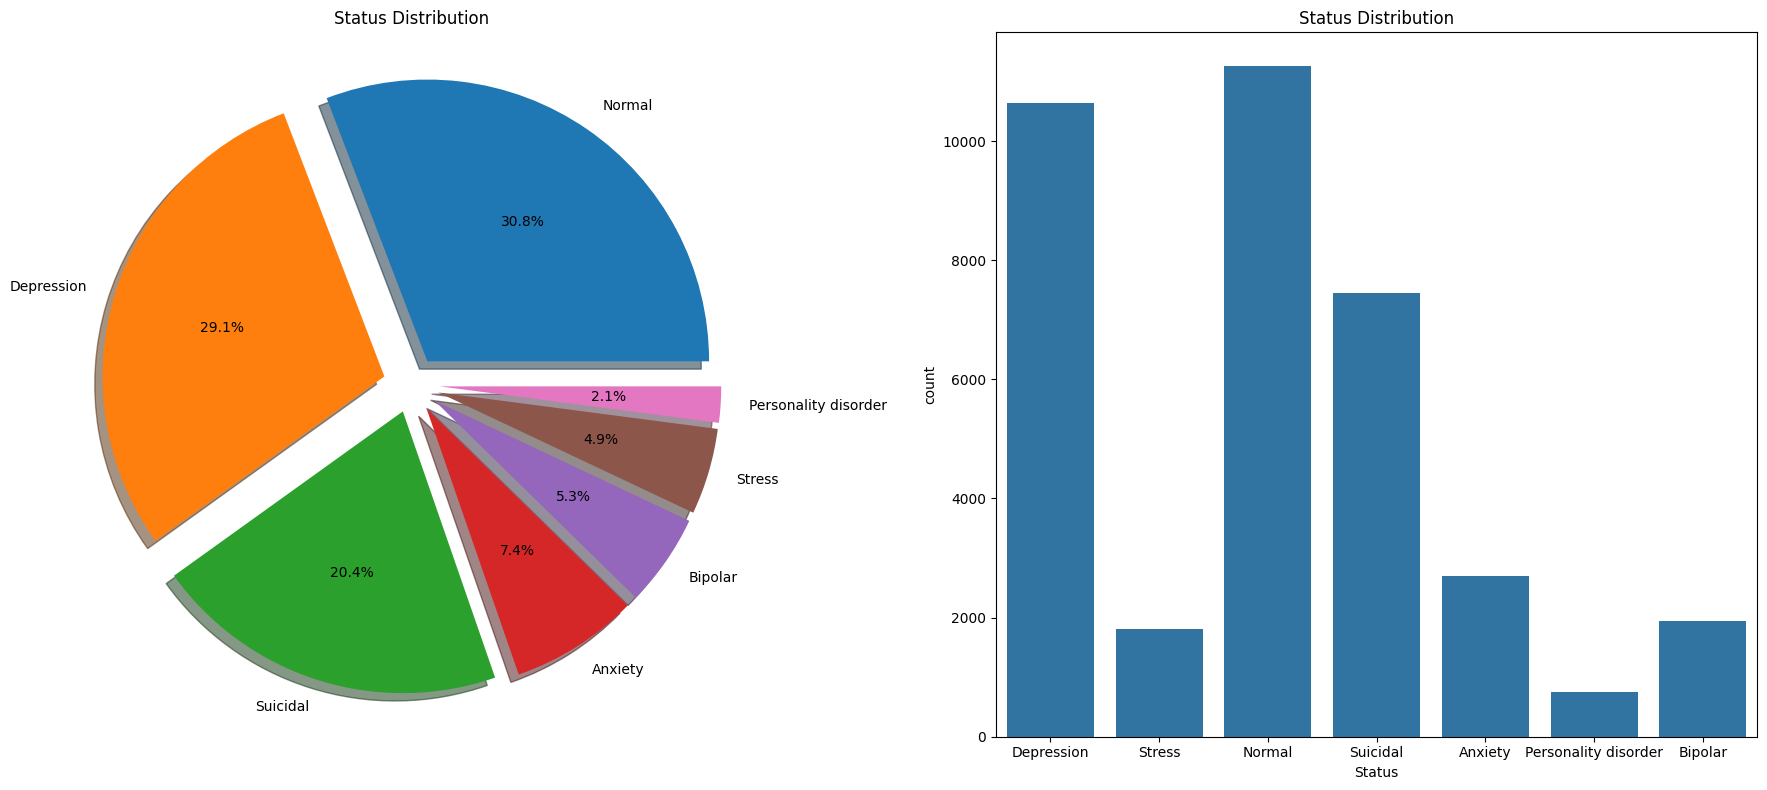

In [7]:
df = df.dropna(subset=['Statement', 'Status'])

duplicate_count = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicate_count}')

# Identify duplicate rows
duplicate_rows = df[df.duplicated()]

print(duplicate_rows['Status'].value_counts())

# Filter the duplicate rows where the status is "Normal" or "Depression"
duplicate_to_drop = duplicate_rows[duplicate_rows['Status'].isin(['Normal', 'Depression'])]

# Drop those specific rows
df = df.drop(duplicate_to_drop.index)

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot pie chart of the target variable with sorted values
df['Status'].value_counts().sort_values(ascending=False).plot.pie(explode=[0.1] * len(df['Status'].value_counts()), autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Status Distribution')
ax[0].set_ylabel('')

# Plot countplot for the target variable
sns.countplot(x='Status', data=df, ax=ax[1])
ax[1].set_title('Status Distribution')

# Show the plot
plt.tight_layout()  # To ensure that the subplots don't overlap
plt.show()

In [8]:
#Data augmentation
def augment_text(text):
    try:
        blob = TextBlob(text)
        translated = blob.translate(to='fr').translate(to='en')
        return str(translated)
    except Exception as e:
        return text

df['augmented_statement'] = df.apply(lambda row: augment_text(row['Statement'])
                                     if row['Status'] in ['Anxiety', 'Stress','Bipolar','Personality disorder'] else None, axis=1)
translated_rows = df[df['augmented_statement'].notna()]
translated_rows['Statement'] = translated_rows['augmented_statement']

# Step 4: Add only the translated rows back to the original dataframe
df = pd.concat([df, translated_rows[['Statement', 'Status']]])

# Optionally, drop the 'augmented_statement' column if you no longer need it
df = df.drop(columns=['augmented_statement'])

C:\Users\User\AppData\Local\Temp\ipykernel_11068\2028483662.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  translated_rows['Statement'] = translated_rows['augmented_statement']


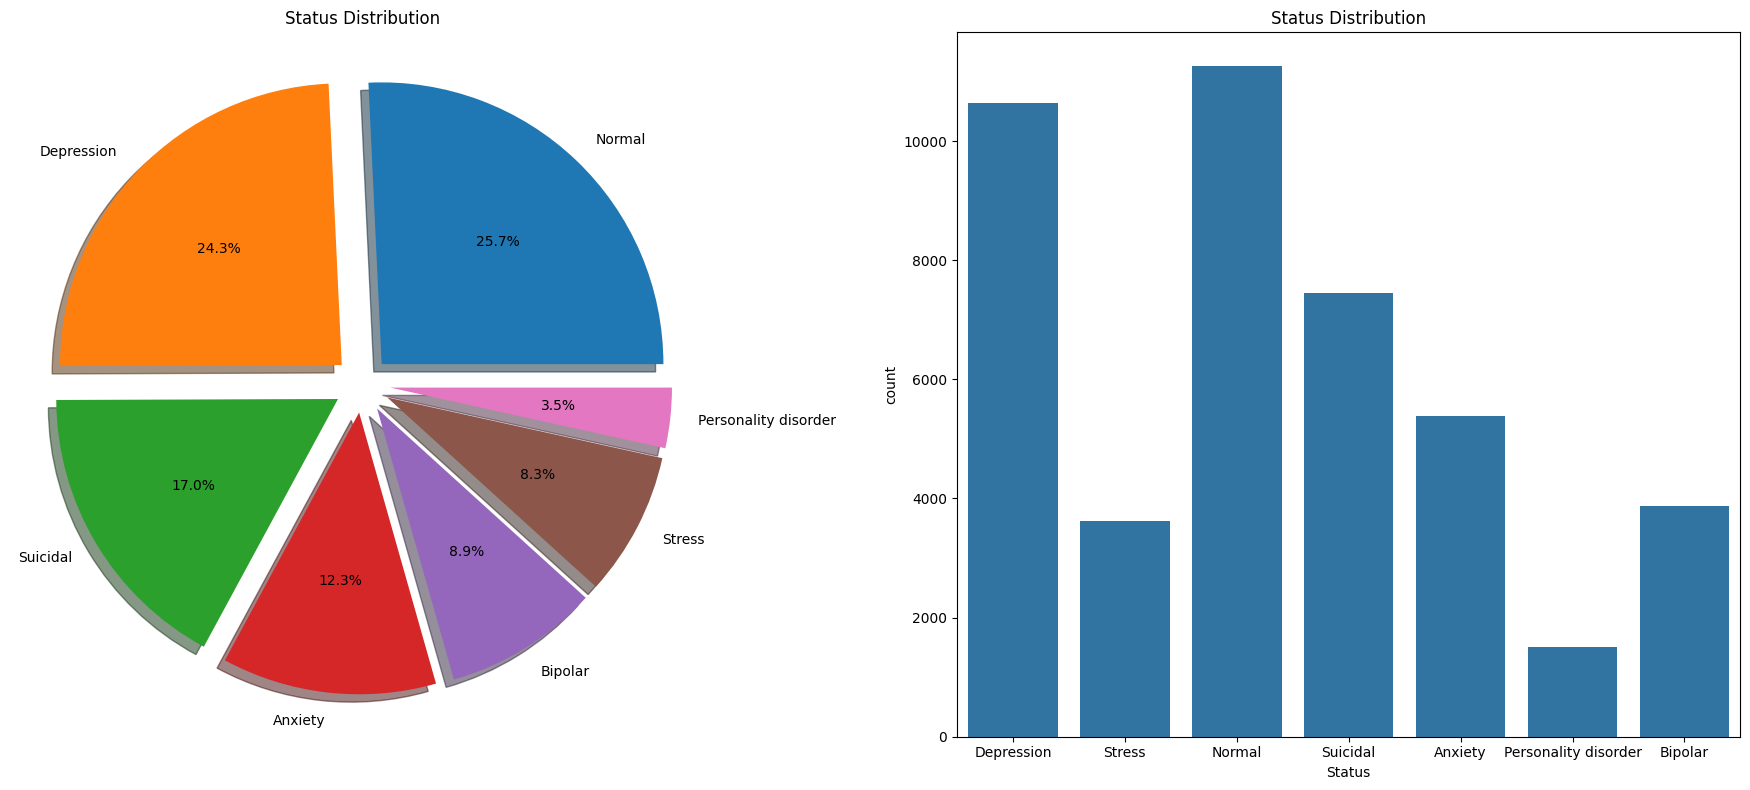

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot pie chart of the target variable with sorted values
df['Status'].value_counts().sort_values(ascending=False).plot.pie(explode=[0.1] * len(df['Status'].value_counts()), autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Status Distribution')
ax[0].set_ylabel('')

# Plot countplot for the target variable
sns.countplot(x='Status', data=df, ax=ax[1])
ax[1].set_title('Status Distribution')

# Show the plot
plt.tight_layout()  # To ensure that the subplots don't overlap
plt.show()

In [9]:
nltk.download('stopwords')
nltk.download('punkt')

stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

stop_words = set(stopwords.words('english'))

def remove_stopwords_and_stem(text):
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['Statement'] = df['Statement'].apply(lambda x: preprocess_text(x))
df['Statement'] = df['Statement'].apply(lambda x: remove_stopwords_and_stem(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
label_encoder = LabelEncoder()
df['Status'] = label_encoder.fit_transform(df['Status'])

In [9]:
df.head()

,Statement,Status
0,life ’ feel worth ’ kind ’ made lot discoveri ...,2
1,life suck religi belief suicid send hell would...,2
2,month marriag manag sleep light cant even thin...,5
3,feel particularli sad anxiou anyth feel like w...,2
4,take venlafaxin ssri cure depress certainli ta...,2


In [11]:
X = df['Statement']
y = df['Status']

In [12]:
vectorizer = TfidfVectorizer(
    max_features=5000,            
    stop_words='english'
)

#TF-IDF Vectorization approach: good for xgboost, Logistic Regression, Naive Bayes, SVM
# will use the original set and change the class weights when training the models
X_tfidf = vectorizer.fit_transform(X).toarray()

In [13]:
#Tokenization and Padding Approach: good for deep learning models like RNNs, LSTMs, CNNs
# will use the original set and change the class weights when training the models
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=100)

In [20]:
# will use the smote technique to create synthetic samples by interpolating between examples in the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_tfidf_smote, y_tfidf_smote = smote.fit_resample(X_tfidf, y)
X_smote_padded, y_smote_padded = smote.fit_resample(X_padded, y)

In [13]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf_smote, y_tfidf_smote, test_size=0.2, random_state=42)


In [ ]:
# Training model

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train_tfidf, y_train)

# Predict
y_pred = model.predict(X_test_tfidf)
 # Make predictions
y_train_pred = model.predict(X_train_tfidf)


In [33]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

# Evaluate Train and Test dataset
model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_pred)

print('Model performance for Training set')
print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
print("- R2 Score: {:.4f}".format(model_train_r2))

print('----------------------------------')

print('Model performance for Test set')
print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
print("- R2 Score: {:.4f}".format(model_test_r2))


Model performance for Training set
- Root Mean Squared Error: 0.0996
- Mean Absolute Error: 0.0036
- R2 Score: 0.9975
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.0860
- Mean Absolute Error: 0.3242
- R2 Score: 0.7042


In [29]:
# Evaluate model
print("Classification Report")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report
                      precision    recall  f1-score   support

             Anxiety       0.95      0.98      0.96      2197
             Bipolar       0.98      0.98      0.98      2287
          Depression       0.79      0.65      0.71      2242
              Normal       0.86      0.92      0.89      2258
Personality disorder       1.00      0.99      0.99      2243
              Stress       0.97      0.97      0.97      2284
            Suicidal       0.73      0.79      0.76      2259

            accuracy                           0.90     15770
           macro avg       0.90      0.90      0.90     15770
        weighted avg       0.90      0.90      0.90     15770



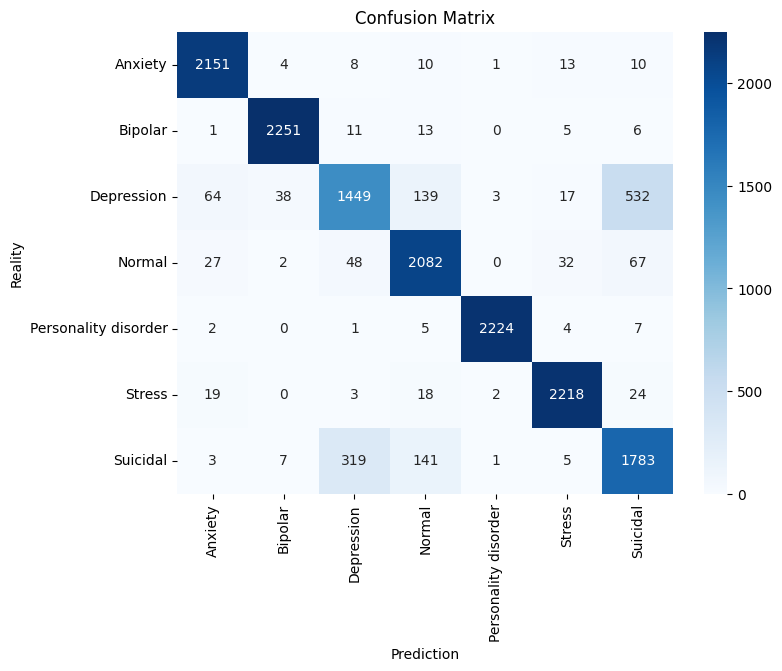

In [30]:
# Confusion matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Reality")
plt.show()

In [31]:
# Make prediction
def predict_mental_health_status(text):
    # Vectorize the input text
    text_vec = vectorizer.transform([text])
    
    # Make the prediction
    prediction = model.predict(text_vec)
    
    # Convert the numerical prediction to the original category
    status = label_encoder.inverse_transform(prediction)
    
    return status[0]

In [32]:
# Example usage
text_1 = "I feel empty and numb. Nothing excites me anymore."
result = predict_mental_health_status(text_1)
print(f"The predicted mental health status for the given text is: {result}")

text_2 = "I am feeling great and excited about the future."
result = predict_mental_health_status(text_2)
print(f"The predicted mental health status for the given text is: {result}")

text_3 = "I am feeling very anxious and stressed about work."
result = predict_mental_health_status(text_3)
print(f"The predicted mental health status for the given text is: {result}")

text_4 = "I don't see a reason to continue living, I just wanna die."
result = predict_mental_health_status(text_4)
print(f"The predicted mental health status for the given text is: {result}")

text_5 = "I act impulsively and regret it later."
result = predict_mental_health_status(text_5)
print(f"The predicted mental health status for the given text is: {result}")

The predicted mental health status for the given text is: Normal
The predicted mental health status for the given text is: Normal
The predicted mental health status for the given text is: Anxiety
The predicted mental health status for the given text is: Suicidal
The predicted mental health status for the given text is: Normal


In [17]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

models = {
    "K-Neighbors Regressor": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBRegressor": XGBClassifier()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train_tfidf, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train_tfidf)
    y_test_pred = model.predict(X_test_tfidf)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 1.3590
- Mean Absolute Error: 0.5740
- R2 Score: 0.5387
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.6138
- Mean Absolute Error: 0.7857
- R2 Score: 0.3467


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 0.1002
- Mean Absolute Error: 0.0036
- R2 Score: 0.9975
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.3693
- Mean Absolute Error: 0.5135
- R2 Score: 0.5297


XGBRegressor
Model performance for Training set
- Root Mean Squared Error: 0.9985
- Mean Absolute Error: 0.2821
- R2 Score: 0.7510
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.3003
- Mean Absolute Error: 0.4684
- R2 Score: 0.5759




In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout

In [31]:
# Build the CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=10000, output_dim=128))  # Removed input_length
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(7, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(X_train, y_train, epochs=5, validation_split=0.2, batch_size=32)

Epoch 1/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5226 - loss: 1.2806 - val_accuracy: 0.7344 - val_loss: 0.7012
Epoch 2/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7667 - loss: 0.6226 - val_accuracy: 0.7700 - val_loss: 0.5807
Epoch 3/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8542 - loss: 0.3939 - val_accuracy: 0.7969 - val_loss: 0.5423
Epoch 4/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9143 - loss: 0.2449 - val_accuracy: 0.8033 - val_loss: 0.5887
Epoch 5/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9516 - loss: 0.1439 - val_accuracy: 0.8013 - val_loss: 0.7122


In [32]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Predictions
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluation
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_classes))

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7948 - loss: 0.6964
Test Accuracy: 0.7950857281684875
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy Score:
0.7950857142857143
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1089
           1       0.92      0.90      0.91       769
           2       0.67      0.73      0.70      2150
           3       0.92      0.88      0.90      2193
           4       0.90      0.79      0.84       331
           5       0.80      0.87      0.83       725
           6       0.64      0.58      0.61      1493

    accuracy                           0.80      8750
   macro avg       0.82      0.81      0.81      8750
weighted avg       0.80      0.80      0.79      8750



In [58]:
def predict_status(statement, tokenizer, model, label_encoder):
    # Preprocess the input statement
    processed_statement = preprocess_text(statement)
    processed_statement = remove_stopwords_and_stem(processed_statement)
    
    # Tokenize and pad the statement
    sequence = tokenizer.texts_to_sequences([processed_statement])
    padded_sequence = pad_sequences(sequence, maxlen=100)
    
    # Predict the status
    prediction = model.predict(padded_sequence)
    predicted_class = np.argmax(prediction, axis=1)[0]
    
    # Map the predicted class to the status label
    predicted_status = label_encoder.inverse_transform([predicted_class])[0]
    
    return predicted_status


# Example usage:
statement_to_predict = 'I met a guy on Tinder three months ago, and I really like him. He says he feels the same, but his actions don’t seem to match his words. We’re both in our late twenties and want a serious relationship, but we’ve only seen each other about five or six times in those three months. He confessed that he’s been feeling depressed, which is why he’s been distant—taking hours to reply to messages while still being online and not being more involved in the relationship. He wasn’t like this at the beginning, and I’m not sure if he was already struggling then or if this has developed more recently. I’ve had trust issues from a past relationship, so I’m not sure I fully believe him, even though I really want to. I want to keep him in my life and take things to the next level, but I’m not sure how to support him, especially this early in the relationship, especially when he can’t give me the kind of relationship I want. He says he can’t offer consistency and that he might feel motivated one day but lack desire the next. I’m not sure what to do or how to help him, but I want to be there for him.'
predicted_status = predict_status(statement_to_predict, tokenizer, cnn_model, label_encoder)
print(f"The predicted status for the given statement is: {predicted_status}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
The predicted status for the given statement is: Bipolar


In [54]:
# Example usage:
statement_to_predict = 'I’m excited, but I don’t really know why—there’s no clear reason. I’m nervous, my stomach hurts, and I’m scared, yet I’m aware that I’m tired. This is the third time it’s happened today, haha—just... haha :)'
predicted_status = predict_status(statement_to_predict, tokenizer, cnn_model, label_encoder)
print(f"The predicted status for the given statement is: {predicted_status}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
The predicted status for the given statement is: Anxiety


In [53]:
# Example usage:
statement_to_predict = 'The problem is, the mistakes I’ve made are the kind I can’t fix because I won’t be on shift to address them. I’m not sure what to say to be helpful or to ease the tension. I honestly feel like all my coworkers hate me, just like everyone else has. Ive already had three panic attacks at work.'
predicted_status = predict_status(statement_to_predict, tokenizer, cnn_model, label_encoder)
print(f"The predicted status for the given statement is: {predicted_status}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
The predicted status for the given statement is: Stress


In [50]:
# Example usage:
statement_to_predict = 'I felt like I came off as really rude today, and I’m struggling with it. I went to the mall to buy some fragrances, and I ended up acting like a jerk to the cashiers. There was only one girl at the counter when I arrived, so I thought I’d be fine, but I was wrong. She seemed new, and when I asked for the fragrance I wanted, she looked confused and said she’d get someone to help me. She returned with two other women, and they all just stared at me while I explained what I was looking for. One of the women started asking me questions, and I wasn’t prepared for that, so I kind of shut down. She asked what fragrance I was wearing, and I lied and said I wasn’t wearing anything. Then she asked if I’d wear something sweeter than the fragrance I picked, and I just shook my head and started looking at other bottles. I acted pretty dismissive toward them because I was really uncomfortable and just wanted to get out of there. I ended up grabbing a fragrance I already knew and just told them I’d buy that one.'
predicted_status = predict_status(statement_to_predict, tokenizer, cnn_model, label_encoder)
print(f"The predicted status for the given statement is: {predicted_status}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The predicted status for the given statement is: Personality disorder


In [64]:
from sklearn.linear_model import LogisticRegression
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf_smote, y_tfidf_smote, test_size=0.2, random_state=42)


reg_model = LogisticRegression(max_iter=1000,C=100)
reg_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = reg_model.predict(X_test_tfidf)

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy Score:
0.8360811667723526
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2197
           1       0.96      0.99      0.97      2287
           2       0.70      0.60      0.64      2242
           3       0.75      0.74      0.74      2258
           4       0.93      0.97      0.95      2243
           5       0.87      0.94      0.91      2284
           6       0.69      0.67      0.68      2259

    accuracy                           0.84     15770
   macro avg       0.83      0.84      0.83     15770
weighted avg       0.83      0.84      0.83     15770



In [69]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [70]:
import torch

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    
    with torch.no_grad():
        outputs = bert_model(**inputs)
    
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings[0].numpy()

In [71]:
X = df['Statement'][::10].values
y = df['Status'][::10].values

embeddings = np.array([get_bert_embedding(text) for text in X])

X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=101)

In [76]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=42)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [77]:
y_pred = xgb.predict(X_test)

In [78]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.6491428571428571
              precision    recall  f1-score   support

           0       0.75      0.68      0.71       116
           1       0.70      0.64      0.67        66
           2       0.56      0.62      0.59       212
           3       0.78      0.89      0.83       235
           4       0.61      0.34      0.44        32
           5       0.55      0.46      0.50        63
           6       0.49      0.43      0.46       151

    accuracy                           0.65       875
   macro avg       0.63      0.58      0.60       875
weighted avg       0.64      0.65      0.64       875



In [79]:
from sklearn.naive_bayes import MultinomialNB
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf_smote, y_tfidf_smote, test_size=0.2, random_state=42)

mnb=MultinomialNB()

mnb.fit(X_train_tfidf,y_train)
y_pred=mnb.predict(X_test_tfidf)
                   
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      2197
           1       0.82      0.85      0.84      2287
           2       0.58      0.53      0.55      2242
           3       0.83      0.58      0.69      2258
           4       0.74      0.91      0.82      2243
           5       0.74      0.70      0.72      2284
           6       0.66      0.72      0.69      2259

    accuracy                           0.73     15770
   macro avg       0.73      0.73      0.73     15770
weighted avg       0.73      0.73      0.73     15770



In [80]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_tfidf, y_train)
print("Best Parameters:", grid.best_params_)

Best Parameters: {'alpha': 0.01}


In [81]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(grid, X_train_tfidf, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average CV Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.73803107 0.73715916 0.73359226 0.73690052 0.74284582]
Average CV Accuracy: 0.7377057664288796
